In [1]:
import numpy as np
import torch
import torch.nn as nn 
import torch.optim as optim 
from torch.autograd import Variable 
from IPython.display import clear_output
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print(torch.cuda.get_device_name(2))

print(torch.cuda.is_available())

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.device_count()

GeForce GTX 1080 Ti
True
cuda:2


6

In [2]:
data_mean = 4
data_stddev = 1.25

In [3]:
(name, preprocess, d_input_func) = ("Only 4 moments", lambda data: get_moments(data), lambda x: 4)

In [4]:
print("Using data [%s]" % (name))

Using data [Only 4 moments]


In [5]:
def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n))).to(device)  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n).to(device)  # Uniform-dist data into generator, _NOT_ Gaussian

# ##### MODELS: Generator model and discriminator model

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
        return self.f(self.map3(x))

def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def get_moments(d):
    # Return the first 4 moments of the data provided
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  # excess kurtosis, should be 0 for Gaussian
    final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
    return final

def decorate_with_diffs(data, exponent, remove_raw_data=False):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    if remove_raw_data:
        return torch.cat([diffs], 1)
    else:
        return torch.cat([data, diffs], 1)

Plotting the generated distribution...


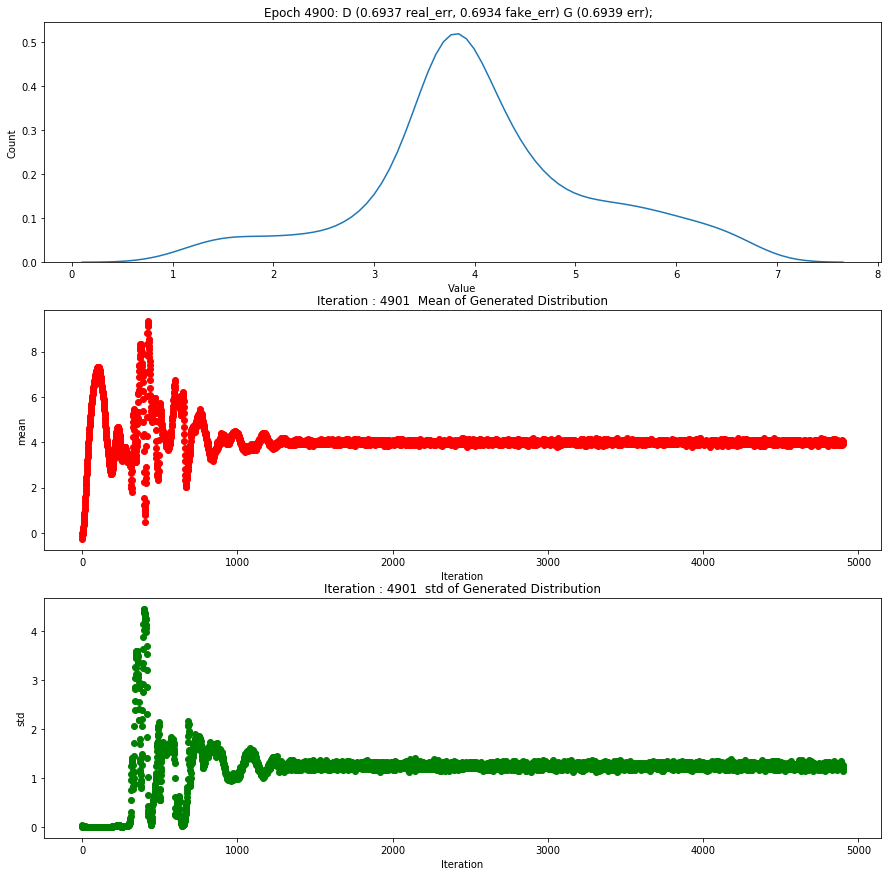

In [6]:

def train():
    # Model parameters
    g_input_size = 1      # Random noise dimension coming into generator, per output vector
    g_hidden_size = 5     # Generator complexity
    g_output_size = 1     # Size of generated output vector
    d_input_size = 500    # Minibatch size - cardinality of distributions
    d_hidden_size = 10    # Discriminator complexity
    d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification
    minibatch_size = d_input_size

    d_learning_rate = 1e-3
    g_learning_rate = 1e-3
    sgd_momentum = 0.9

    num_epochs = 5000
    print_interval = 100
    d_steps = 20
    g_steps = 20

    dfe, dre, ge = 0, 0, 0
    d_real_data, d_fake_data, g_fake_data = None, None, None

    discriminator_activation_function = torch.sigmoid
    generator_activation_function = torch.tanh

    d_sampler = get_distribution_sampler(data_mean, data_stddev)
    gi_sampler = get_generator_input_sampler()
    G = Generator(input_size=g_input_size,
                  hidden_size=g_hidden_size,
                  output_size=g_output_size,
                  f=generator_activation_function).to(device)
    D = Discriminator(input_size=d_input_func(d_input_size),
                      hidden_size=d_hidden_size,
                      output_size=d_output_size,
                      f=discriminator_activation_function).to(device)
    criterion = nn.BCELoss().to(device) # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
    d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
    g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate )
    
    iteration , mean , std = 0 , 0 , 0
    output = pd.DataFrame({"iter" : [iteration] , "mean" : [mean] , "std" : [std]})
    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real
            d_real_data = Variable(d_sampler(d_input_size))
            d_real_decision = D(preprocess(d_real_data))
            d_real_error = criterion(d_real_decision, Variable(torch.ones([1,1]).to(device)))  # ones = true
            d_real_error.backward() # compute/store gradients, but don't change params

            #  1B: Train D on fake
            d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = criterion(d_fake_decision, Variable(torch.zeros([1,1]).to(device)))  # zeros = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

            dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            g_error = criterion(dg_fake_decision, Variable(torch.ones([1,1]).to(device)))  # Train G to pretend it's genuine

            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters
            ge = extract(g_error)[0]

        if epoch % print_interval == 0:
            print("Epoch %s: D (%s real_err, %s fake_err) G (%s err); Real Dist (%s),  Fake Dist (%s) " %
                  (epoch, dre, dfe, ge, stats(extract(d_real_data)), stats(extract(d_fake_data))))
        
        
        iteration +=1
        values = extract(g_fake_data)
        mean = np.mean(values)
        std = np.std(values)
        output1 = pd.DataFrame({"iter" : [iteration] , "mean" : [mean] , "std" : [std]})
        output = output.append(output1)
        if epoch % 100 == 0 :
            clear_output(wait= True)
            fig = plt.figure(figsize = (15, 15))
            ax1 = fig.add_subplot(3,1,1)
            ax2 = fig.add_subplot(3,1,2)
            ax3 = fig.add_subplot(3,1,3)
            print("Plotting the generated distribution...")
            ax2.plot( output.iter , output["mean"], 'ro')
            ax2.set_xlabel("Iteration")
            ax3.set_xlabel("Iteration")
            ax2.set_ylabel("mean")
            ax3.set_ylabel("std")
            ax2.set_title('Iteration : {}  Mean of Generated Distribution'.format(iteration))
            ax3.set_title('Iteration : {}  std of Generated Distribution'.format(iteration))
            ax3.plot( output.iter , output["std"], 'go')
            #print(" Values: %s" % (str(values)))
            sns.kdeplot( values , ax = ax1)
            ax1.set_xlabel('Value')
            ax1.set_ylabel('Count')
            ax1.set_title("Epoch %s: D (%s real_err, %s fake_err) G (%s err);  " %
                  (epoch, round(dre,4), round(dfe,4), round(ge,4)))
            plt.grid(False)
            plt.show()


train()

## 평균이 4 표준편차는 1.5 
    * 목표로 하는 분포는 평균이 4 표준편차는 1.5를 나타낸다
    * 그러나 kernel density 로 파악을 해보면 약간 쌍봉 형태로 나타나게 된다.
    * 여기서 D 는 데이터 1.평균 , 2.잔차 3.왜도 4.첨도 기준으로 판단하게 된다.
        * 그래서 이 4가지 조건에서만 G가 달성하면 D는 속게 된다.

## GPU
    * 사용하는 TENSOR에 .to(device) 이런식으로 넣어주면 돌아가는 것 같다.

In [7]:
n = 10 
mu = 0 
sigma = 1 
torch.Tensor(np.random.normal(mu, sigma, (1, n))).cuda()


tensor([[ 1.3771, -0.8693,  0.7400, -0.2607, -0.8174, -0.9412,  0.7873, -0.7265,
          1.3371, -0.2109]], device='cuda:0')